In [50]:
import numpy as np
import time
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.io import savemat

In [41]:
#funkcja generująca losową macierz o rozmiarze nxn i wartościach z przedziału (0.00000001, 1.0) 

def generate_matrix(n):
    return np.random.uniform(0.00000001, 1.0,(n,n))

# Funkcja pomocnicza do znajdowania najbliższej potęgi dwójki
def next_power_of_two(n):
    return 1 if n == 0 else 2**(n - 1).bit_length()

# Funkcja do pad'owania macierzy do parzystego rozmiaru
def pad_matrix_to_even_size(A):
    (n, m) = A.shape
    if n % 2 != 0:  # Sprawdzenie, czy rozmiar jest nieparzysty
        A = np.pad(A, ((0, 1), (0, 1)), mode='constant', constant_values=0)
    return A


# Funkcja rozszerzająca macierz do rozmiaru będącego potęgą dwójki
def pad_matrix_to_power_of_two(A):
    (n, m) = A.shape
    new_size = next_power_of_two(max(n, m))
    padded_matrix = np.zeros((new_size, new_size))
    padded_matrix[:n, :m] = A
    return padded_matrix

# Funkcja przycinająca macierz do oryginalnego rozmiaru
def unpad_matrix(C, original_size):
    return C[:original_size, :original_size]

In [42]:
# Funkcja rekurencyjna do mnożenia macierzy metodą Bineta z obsługą paddingu
def binet_multiply(A, B):
    n = A.shape[0]
    
    if n == 1:
        return A * B
    elif n % 2 != 0:  # Jeżeli rozmiar macierzy jest nieparzysty, dodaj padding
        A = pad_matrix_to_even_size(A)
        B = pad_matrix_to_even_size(B)
        n += 1  # Zwiększamy rozmiar
    
    mid = n // 2
    A11, A12, A21, A22 = A[:mid, :mid], A[:mid, mid:], A[mid:, :mid], A[mid:, mid:]
    B11, B12, B21, B22 = B[:mid, :mid], B[:mid, mid:], B[mid:, :mid], B[mid:, mid:]

    C11 = binet_multiply(A11, B11) + binet_multiply(A12, B21)
    C12 = binet_multiply(A11, B12) + binet_multiply(A12, B22)
    C21 = binet_multiply(A21, B11) + binet_multiply(A22, B21)
    C22 = binet_multiply(A21, B12) + binet_multiply(A22, B22)

    C = np.vstack((np.hstack((C11, C12)), np.hstack((C21, C22))))
    return unpad_matrix(C, A.shape[0])  # Przycinanie do oryginalnego rozmiaru


In [43]:
# Funkcja do mnożenia macierzy metodą Strassena z obsługą paddingu dla nieparzystych wymiarów
def strassen_multiply(A, B):
    n = A.shape[0]
    
    if n == 1:
        return A * B
    
    # Sprawdzamy, czy macierze mają nieparzysty wymiar, jeśli tak - pad'ujemy
    if n % 2 != 0:
        A = pad_matrix_to_even_size(A)
        B = pad_matrix_to_even_size(B)
        n += 1  # Zwiększamy rozmiar po pad'owaniu
    
    # Dzielenie macierzy na podmacierze
    mid = n // 2
    A11, A12, A21, A22 = A[:mid, :mid], A[:mid, mid:], A[mid:, :mid], A[mid:, mid:]
    B11, B12, B21, B22 = B[:mid, :mid], B[:mid, mid:], B[mid:, :mid], B[mid:, mid:]

    # Obliczanie pomocniczych macierzy M
    M0 = strassen_multiply(A11 + A22, B11 + B22)
    M1 = strassen_multiply(A21 + A22, B11)
    M2 = strassen_multiply(A11, B12 - B22)
    M3 = strassen_multiply(A22, B21 - B11)
    M4 = strassen_multiply(A11 + A12, B22)
    M5 = strassen_multiply(A21 - A11, B11 + B12)
    M6 = strassen_multiply(A12 - A22, B21 + B22)

    # Składanie wynikowej macierzy
    C11 = M0 + M3 - M4 + M6
    C12 = M2 + M4
    C21 = M1 + M3
    C22 = M0 + M2 - M1 + M5

    # Łączenie podmacierzy w jedną macierz
    C = np.vstack((np.hstack((C11, C12)), np.hstack((C21, C22))))
    
    # Przycinanie macierzy do oryginalnego rozmiaru
    return unpad_matrix(C, A.shape[0])

In [53]:
n = 50
A = generate_matrix(n)
B = generate_matrix(n)

mat_data = {'A': A, 'B': B}
savemat('matrix_data.mat', mat_data)

# Rozszerzenie macierzy do rozmiaru będącego potęgą 2
A_padded = pad_matrix_to_power_of_two(A)
B_padded = pad_matrix_to_power_of_two(B)

# Mnożenie metodą Binéta
start_time = time.time()
C_binet = binet_multiply(A, B)
end_time = time.time()

print("Mnożenie macierzy metodą Binéta (rekurencyjnie):")
print(end_time-start_time)

# Mnożenie metodą Strassena
start_time = time.time()
C_strassen = strassen_multiply(A, B)
print("\nMnożenie macierzy metodą Strassena:")
end_time = time.time()
print(end_time-start_time)


Mnożenie macierzy metodą Binéta (rekurencyjnie):
0.7518553733825684

Mnożenie macierzy metodą Strassena:
0.5985684394836426


Oszacowane wartości: a = 2.0954717259262e-05, k = 3.0542590431536216


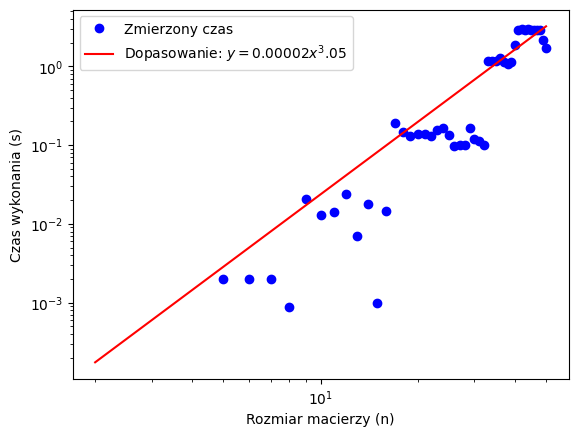

In [45]:
# Funkcja do mierzenia czasu mnożenia macierzy
def measure_time(n):
    A = generate_matrix(n)
    B = generate_matrix(n)
    start_time = time.time()
    C = binet_multiply(A, B)
    end_time = time.time()
    return end_time - start_time

sizes = list(range(2, 51))  
times = [measure_time(n) for n in sizes]

# Dopasowanie funkcji y = a * x^k
def model_function(x, a, k):
    return a * x**k

popt, pcov = curve_fit(model_function, sizes, times)
a, k = popt

# Wypisanie wyników
print(f"Oszacowane wartości: a = {a}, k = {k}")

# Wizualizacja
plt.figure()
plt.loglog(sizes, times, 'bo', label="Zmierzony czas")
plt.loglog(sizes, model_function(np.array(sizes), *popt), 'r-', label=f"Dopasowanie: $y = {a:.5f} x^{k:.2f}$")
plt.xlabel('Rozmiar macierzy (n)')
plt.ylabel('Czas wykonania (s)')
plt.legend()
plt.show()

Oszacowane wartości dla Strassena: a = 0.00035695526849895864, k = 1.994077108567285


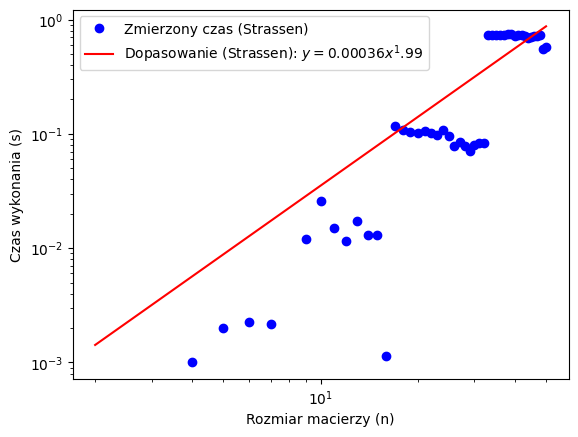

In [48]:
# Funkcja do mierzenia czasu mnożenia macierzy algorytmem Strassena
def strassen_measure_time(n):
    A = generate_matrix(n)
    B = generate_matrix(n)
    start_time = time.time()
    C = strassen_multiply(A, B)  
    end_time = time.time()
    return end_time - start_time

# Generowanie danych do analizy dla kwadratowych macierzy: 2x2, 3x3, ..., 50x50
strassen_sizes = list(range(2, 51))  
strassen_times = [strassen_measure_time(n) for n in strassen_sizes]

# Dopasowanie funkcji y = a * x^k
def strassen_model_function(x, a, k):
    return a * x**k

strassen_popt, strassen_pcov = curve_fit(strassen_model_function, strassen_sizes, strassen_times)
strassen_a, strassen_k = strassen_popt

# Wypisanie wyników
print(f"Oszacowane wartości dla Strassena: a = {strassen_a}, k = {strassen_k}")

# Wizualizacja dla algorytmu Strassena
plt.figure()
plt.loglog(strassen_sizes, strassen_times, 'bo', label="Zmierzony czas (Strassen)")
plt.loglog(strassen_sizes, strassen_model_function(np.array(strassen_sizes), *strassen_popt), 'r-', label=f"Dopasowanie (Strassen): $y = {strassen_a:.5f} x^{strassen_k:.2f}$")
plt.xlabel('Rozmiar macierzy (n)')
plt.ylabel('Czas wykonania (s)')
plt.legend()
plt.show()
